In [4]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25096), started 5 days, 2:23:44 ago. (Use '!kill 25096' to kill it.)

#### Loading the relevant datasets (15/100)

Training Shape: 
 (11040, 2)
['image_path' 'target']
Testing Shape: 
 (2760, 2)
['image_path' 'target']
Label Dimensionality: 
 (13800, 2)


Text(0.5, 0, 'target')

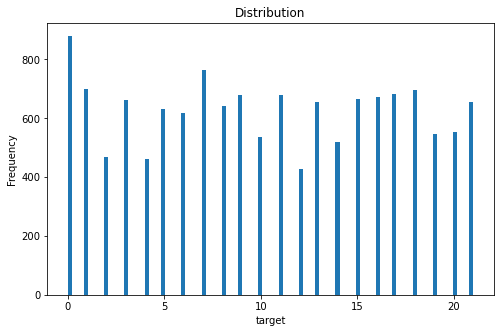

In [5]:
# load the datasets using the csv files train, val and test 
# (3)
# columns remain the same for train, val and test
data_columns = ['img_path', 'target']
df = pd.read_csv('input/data.csv')

training_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data.index)

# print the shapes of the dataframes 
# (3)
print("Training Shape: \n", training_data.shape)
print(df.columns.values)

print("Testing Shape: \n", testing_data.shape)
print(df.columns.values)
# print the column names from either one of the dataframes 
# (1)

print("Label Dimensionality: \n", df.shape)

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
# (2)

che_hist = df['target'].plot.hist(title="Distribution", figsize=(8,5), bins=100)
che_hist.set_xlabel("target")

#### Create the ImageDataGenerators (22/100)

In [6]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
   # imported all possible values here and set ones we wont use to default
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    # fill mode augmentation, at its default currently (nearest)
    fill_mode='nearest',
    cval=0.0,
    # twoaugmentations randomly flip horizontally and vertically
    horizontal_flip=True,
    vertical_flip=True,
    #rescaling change this value as we need to, unsure what we want it to be set to at the moment
    rescale=1,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,
    dtype=None
)


# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)

flowfromframeTrain = train_img_gen.flow_from_directory(
    directory='./input/train',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    subset='training',
    interpolation='nearest'
)
flowfromframeVal = train_img_gen.flow_from_directory(
    directory='./input/train',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    subset='validation',
    interpolation='nearest'
)

test_img_gen = ImageDataGenerator(
   # imported all possible values here and set ones we wont use to default
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    # fill mode augmentation, at its default currently (nearest)
    fill_mode='nearest',
    cval=0.0,
    # twoaugmentations randomly flip horizontally and vertically
    horizontal_flip=True,
    vertical_flip=True,
    #rescaling change this value as we need to, unsure what we want it to be set to at the moment
    rescale=1,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
)

flowfromframeTest = test_img_gen.flow_from_directory(
    directory='./input/test/',
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    interpolation='nearest'
)

# enumerate through the validation data generator created above and plot first grayscale image 
# (2)

Found 10620 images belonging to 22 classes.
Found 2644 images belonging to 22 classes.
Found 1106 images belonging to 22 classes.


#### Create the model (44/100)

In [7]:
model = tf.keras.Sequential()

input_shape = (256, 256, 3)
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)
learn_rate = (0.001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# TODO
# (2)

model_Callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

# ModelCheckpoint
# monitor validation loss and save the best model weights
# TODO
# (2)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./data/model',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)
model_Callbacks.append(model_checkpoint)

# Initiallize TensorBoard
# TODO
# (2)

log_dir = "./data/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)

reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_Callbacks.append(reduceLRCallback)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
    x=flowfromframeTrain,
    y=None,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks=model_Callbacks,
    validation_split=0.0,
    validation_data=flowfromframeVal,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=100,
    validation_steps=0,
    validation_freq=0,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)


AttributeError: module 'tensorflow.python.keras.activations' has no attribute 'get'

#### Making predictions on test data (14/100)

In [ ]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)
scores = model.evaluate(flowfromframeTest)
print(scores)

35/35 [==============================] - 5s 147ms/step - loss: 0.2555 - accuracy: 0.9414
[0.25551971793174744, 0.9413940906524658]


In [ ]:
# generate predictions using the test generator

predictions = model.predict(flowfromframeTest)
# extract the ethnicity predictions

#eth_pred = np.argmax(predictions[0], axis=-1)
# print the classification report for predicting ethnicity
#print(classification_report(flowfromframeTest.index_array, eth_pred))

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
gen_pred = np.around(predictions)
# print the classification report for predicting gender

test_labels=flowfromframeTest.labels

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

NameError: name 'model' is not defined

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
